## **Libraries**

In [ ]:
# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis and modeling libraries
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Additional libraries
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load dataset with preprocessed data
olist_df = pd.read_pickle('notebooks/datasets/processed_dataset.pkl')
olist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114422 entries, 0 to 114421
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   order_id                  114422 non-null  object        
 1   order_purchase_timestamp  114422 non-null  datetime64[ns]
 2   datetime                  114422 non-null  datetime64[ns]
 3   diff_days                 114422 non-null  int64         
 4   weekly                    114422 non-null  UInt32        
 5   product_id                114422 non-null  object        
 6   seller_id                 114422 non-null  object        
 7   price                     114422 non-null  float64       
 8   freight_value             114422 non-null  float64       
 9   product_category_name     114422 non-null  object        
 10  seller_zip_code_prefix    114422 non-null  int64         
 11  seller_city               114422 non-null  object        
 12  se

## **Model RFM and Clustering K-means**

### RFM technique

#### Calculate recency (R)

In [ ]:
# Group the DataFrame by the customer's unique identifier and find the most recent purchase date for each customer using the max() function on the 'order_purchase_timestamp' column.
recency = olist_df.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max()
# Renamed 'order purchase timestamp' for clarity
recency.rename(columns={"order_purchase_timestamp":"last_purchase_date"}, inplace=True)
# Converted to dt.date format
recency["last_purchase_date"] = recency["last_purchase_date"].dt.date
# Recency is calculated by subtracting each customer's most recent purchase date from the overall most recent purchase date
recent_date = olist_df['order_purchase_timestamp'].dt.date.max()
recency['Recency'] = recency['last_purchase_date'].apply(lambda x: (recent_date - x).days)

In [ ]:
recency.head()

,customer_unique_id,last_purchase_date,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,119
2,0000f46a3911fa3c0805444483337064,2017-03-10,542
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,326
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,293


#### Calculating frequency (F)

In [ ]:
# Group the DataFrame by the unique customer identifier 'customer_unique_id' and count the number of unique values in the 'order_id' column for each customer, representing the frequency of purchases for each customer.
frequency = olist_df.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}).reset_index()
frequency.rename(columns={"order_id":"Frequency"}, inplace=True)
frequency.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


#### Calculating monetary (M)

In [ ]:
# Group the DataFrame by the customer's unique identifier 'customer_unique_id' and add the value of the 'payment_value' column for each customer, representing the total monetary value spent by each.
monetary = olist_df.groupby('customer_unique_id', as_index=False)['payment_value'].sum()
monetary.columns = ['customer_unique_id', 'Monetary']
monetary.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


#### Merging RFM

In [ ]:
rf = recency.merge(frequency, on='customer_unique_id')
rfm = rf.merge(monetary, on='customer_unique_id').drop(columns='last_purchase_date')
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
2,0000f46a3911fa3c0805444483337064,542,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,293,1,196.89


In [ ]:
rfm.shape

(92491, 4)

### Replace 0 values

In [ ]:
# Remove zeros from data and replace with value 1 before logarithmic transformation
rfm[rfm.columns[1:]] = rfm[rfm.columns[1:]].applymap(lambda x: 1 if x == 0 else x)

### Check data bias

In [ ]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    # A bias hypothesis test is performed to evaluate whether the distribution is significantly asymmetric.
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s --> Skew: {}, : {}".format(column, skew, skewtest))
    return

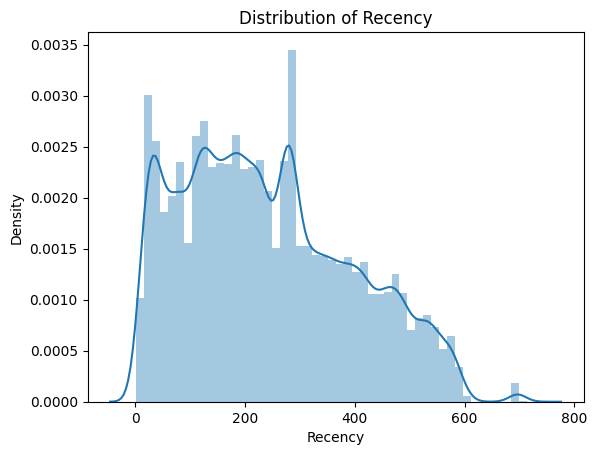

Recency's --> Skew: 0.4522737974658137, : SkewtestResult(statistic=53.623092274124154, pvalue=0.0)


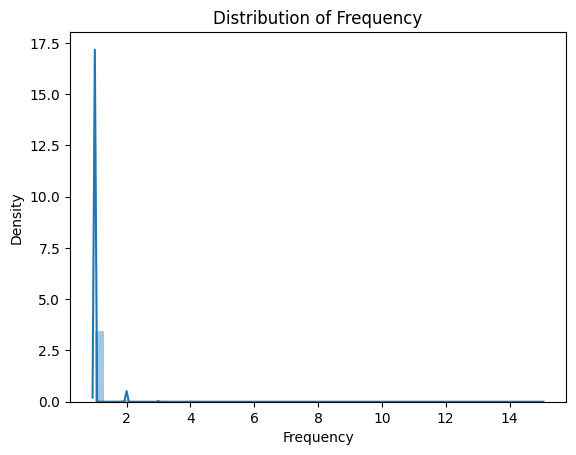

Frequency's --> Skew: 11.088873426187245, : SkewtestResult(statistic=334.9130698530336, pvalue=0.0)


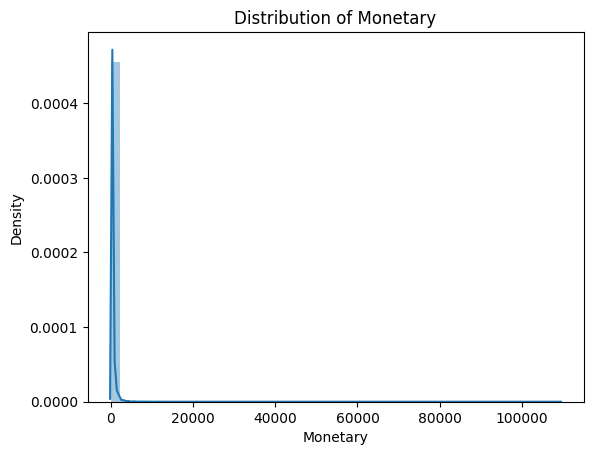

Monetary's --> Skew: 71.82461718541865, : SkewtestResult(statistic=524.2139103612999, pvalue=0.0)


In [ ]:
for col in rfm.columns[1:]:
    check_skew(rfm, col)

> Recency (R):

  * Skewness: The skewness is positive (0.45), indicating a slight right skew in the distribution of the data. This means that there are more customers with lower recency values than with higher values.
  * Skewness test results: The skewness test statistic (53.62) is significantly high, along with an extremely low p-value (close to zero). This suggests that the data distribution is significantly skewed.

> Frequency (F):

  * Skewness: The skewness is positive and quite high (11.09), indicating a strong right skew in the distribution of the data. This suggests that there are many customers with very low purchase frequencies and a few with very high frequencies.
  * Skewness test results: The skewness test statistic (334.91) is extremely high and the p-value is very low (close to zero), indicating significant skewness.

> Monetary (M):

  * Skewness: The skewness is positive and very high (71.82), indicating an extreme right skew in the distribution of the data. This suggests that most customers spend small amounts of money, while a few spend extremely large amounts.
  * Skewness test results: The skewness test statistic (524.21) is extremely high and the p-value is very low (close to zero), confirming the presence of significant skewness.

In summary, these results indicate that all three metrics (Recency, Frequency, and Monetary Value) are highly right-skewed, meaning that there is a concentration of lower values and a few very high values in the distribution of the data.

### Apply the logarithmic function (logn)

In [ ]:
rfm_log = rfm.copy()
# We only transform 'Frequency' and 'Monetary' since 'Recency' does not improve with the transformation
for c in rfm.columns[2:]:
    rfm_log[c] = np.log10(rfm_log[c])

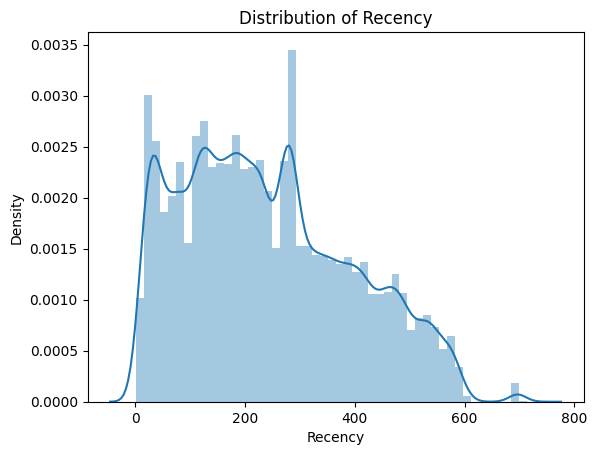

Recency's --> Skew: 0.4522737974658137, : SkewtestResult(statistic=53.623092274124154, pvalue=0.0)


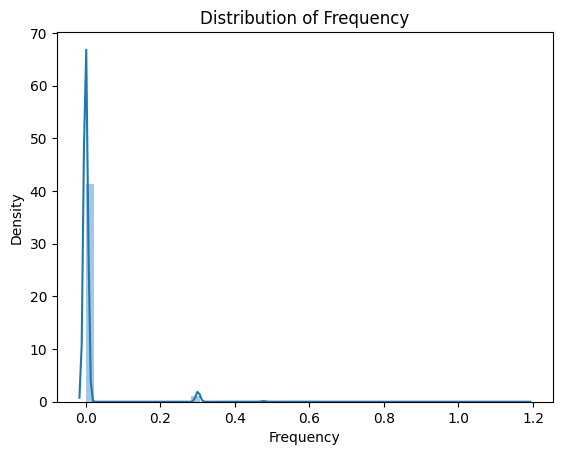

Frequency's --> Skew: 6.088144954310692, : SkewtestResult(statistic=274.4325595231722, pvalue=0.0)


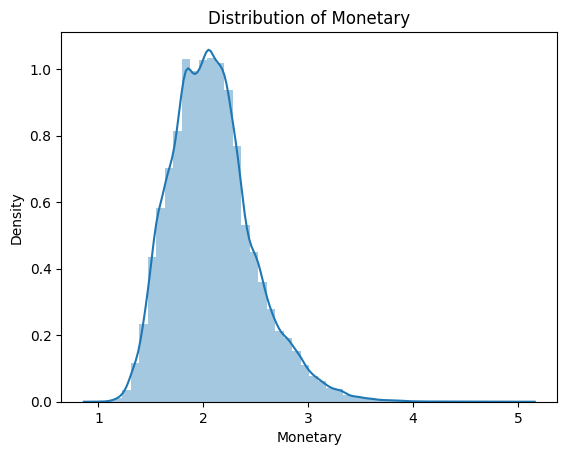

Monetary's --> Skew: 0.7269774770718841, : SkewtestResult(statistic=81.27872946964933, pvalue=0.0)


In [ ]:
for col in rfm.columns[1:]:
    check_skew(rfm_log, col)

### We scale the data

In [ ]:
# Initialize and adjust the scaler
scaler = StandardScaler()
# Fits scaler to transformed RFM data
scaler.fit(rfm_log.drop("customer_unique_id", axis=1))
# Scale data
RFM_table_scaled = scaler.transform(rfm_log.drop("customer_unique_id", axis=1))
# Create a DataFrame with the scaled data (Excluding 'customer unique id')
RFM_table_scaled = pd.DataFrame(RFM_table_scaled, columns=rfm_log.columns[1:])

In [ ]:
RFM_table_scaled.head()

,Recency,Frequency,Monetary
0,-0.824297,-0.171965,0.167637
1,-0.804648,-0.171965,-1.636690
2,1.965984,-0.171965,-0.376433
3,0.551194,-0.171965,-1.120525
4,0.335045,-0.171965,0.525301


### Training k-means model

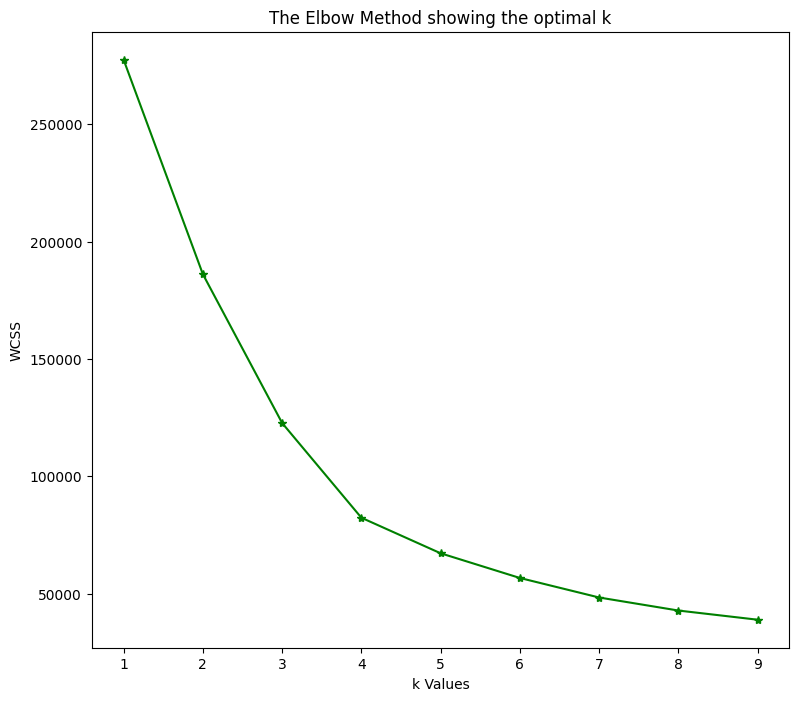

In [ ]:
# Initialization of 'distortions' variables or better known as WCSS
distortions = []
# It's tested with different K
K = range(1,10)
for k in K:
    # K-means model training
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_table_scaled)
    distortions.append(kmeanModel.inertia_)

# Elbow Method Chart
plt.figure(figsize=(9,8))
plt.plot(K, distortions, 'g*-')
plt.xlabel('k Values')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# Train the model on 4 clusters
kmean_model = KMeans(n_clusters=4, random_state=5)
kmean_y = kmean_model.fit_predict(RFM_table_scaled)
# Add the labels to the Dataframe
rfm['Cluster'] = kmean_model.labels_

In [ ]:
rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary,Cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19,1
2,0000f46a3911fa3c0805444483337064,542,1,86.22,3


In [ ]:
# Function to display the average and count using the agg() method to use different functions
def rfm_values(df):
    df_new = df.groupby(['Cluster']).agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'Monetary': ['mean', 'count']
        }).round(2)

    return df_new

In [ ]:
rfm_values(rfm)

Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        193.07      1.00   515.71  22591
1        145.29      1.00    81.43  39777
2        224.92      2.11   484.05   2765
3        424.22      1.00   123.76  27358

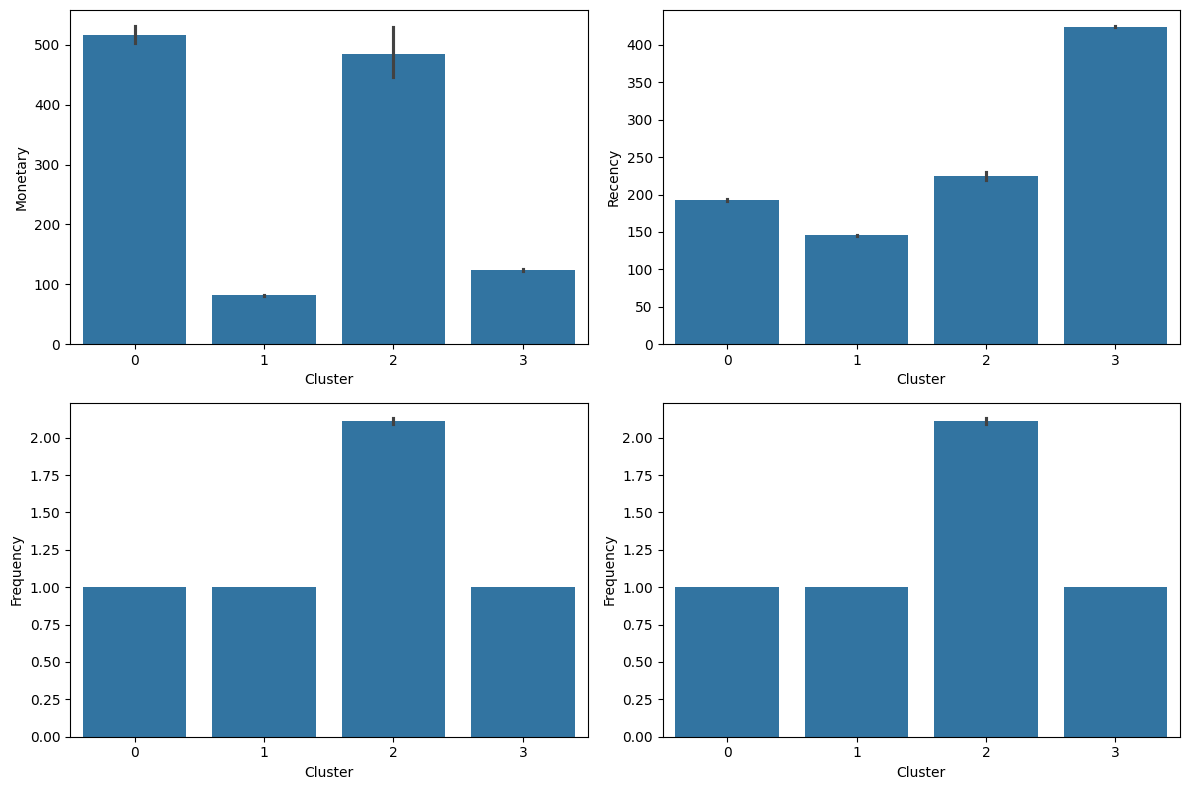

In [ ]:
# Let's see the values more graphically
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Graph 1
sns.barplot(data=rfm, x='Cluster', y='Monetary', ax=axes[0, 0])
# Graph 2
sns.barplot(data=rfm, x='Cluster', y='Recency', ax=axes[0, 1])
# Graph 3
sns.barplot(data=rfm, x='Cluster', y='Frequency', ax=axes[1, 0])
# Graph 4
sns.barplot(data=rfm, x='Cluster', y='Frequency', ax=axes[1, 1])

plt.tight_layout()
plt.show()

Most customers have only placed one order on average (the average order per customer is 1.03). Additionally, most customers have not placed orders in a long time.

**What does each group represent?**

> **Group 0:** This group can be considered our "active and loyal customers." They are the group that spends the most on our products and services (R$516), and their purchases are recent (193 days). This cluster also ranks third in terms of the number of customers (22,591 customers).

> **Group 1:** This group can be interpreted as "relatively new arrivals/low spenders," as their spending is the smallest among all groups (R$81), but they have made more recent purchases than most of the other clusters (145 days). This group is quite large (39,777 customers). Therefore, it might be advisable to make some marketing efforts to increase their monetary value.

> **Group 2:** This group can be considered "customers who make purchases with moderate frequency and generate significant revenue for the company," as although the customers in this group have not placed orders on average for a while (225 days) and are not a very large group (2,765 customers), their order frequency is higher than that of all other groups (2 purchases) and the value of their orders is quite high (R$484).

> **Group 3:** These customers can be considered our "lost and low-spending customers," as their spending is significantly lower compared to the other groups (R$124), and they have made purchases a long time ago compared to most of the other clusters (424 days). This group is one of the largest (27,358 customers). It should not be the focus of marketing efforts.